In [1]:
from torchtext.utils import download_from_url, extract_archive
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import notebook

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sn

import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from argparse import Namespace

from torchtext.legacy import data
from torchtext.vocab import Vectors

import time

In [2]:
args = Namespace(
    faq_csv = ".data/faq_with_splits_lemmatized_filtered.csv",
    save_dir = ".model_storage/lstm",
    model_state_file = "model.pth",
    embedding_dir = '.embedding/',
    glove_file = 'glove-hu.200k.200d.txt',
    gensim_file = 'glove-hu.200k.200d_gensim',
    seed = 1234,
    num_epochs = 40,
    learning_rate = 1e-3,
    batch_size = 70,
    cuda = True,
)

In [3]:
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
args.glove_file = os.path.join(args.embedding_dir, args.glove_file)
args.gensim_file = os.path.join(args.embedding_dir, args.gensim_file)

In [4]:
_ = download_from_url('https://drive.google.com/uc?id=19k2AACA90Qv1BeUBz8H6trCT4QTJ8OjW', root=args.embedding_dir)

In [5]:
_ = glove2word2vec(args.glove_file, args.gensim_file)

In [6]:
embedding = gensim.models.KeyedVectors.load_word2vec_format(args.gensim_file, binary=False)

In [7]:
faq_df = pd.read_csv(args.faq_csv, lineterminator='\n')

In [8]:
train_df = faq_df[faq_df.split == 'train']
val_df = faq_df[faq_df.split == 'val']
test_df = faq_df[faq_df.split == 'test']

In [9]:
train_df.head()

,answer,long_question,short_question,keywords,main_category,sub_category,split
0,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Írnátok nekem valami biztatót? Miután pár napj...,írnátok biztató,"['depresszió', 'gödör', 'szerelem', 'bánat']",Egészség,Mentális egészség,train
1,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Vehetek be az antidepresszánssal egy időben ny...,vehet antidepresszáns idő nyugtató,"['antidepresszáns', 'tea', 'nyugtató', 'gyógyn...",Egészség,Mentális egészség,train
2,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Azt halottam tüdőgyulladással nem nagyon kell ...,az halik tüdőgyulladás fekszik vese gyulladás ...,"['tüdőgyulladás', 'vesegyulladás']",Egészség,Betegségek,train
3,"Ignoráld. A közösségek ilyenek, kinéznek valak...","Mit csináljak, ha szekál az osztályom a miatt,...",mi csinál ha szekál osztály miatt sokatvagy be...,"['szekálás', 'betegség', 'pajzsmirigy', 'hiány...",Egészség,"Immunrendszer, fertőzések",train
4,Kedves kérdező!!Először is nem tudom hány éves...,"Hirtelen nagyon erős lett a vérzésem, egyik pe...",hirtelen erős vérzésem perc amásikra ömlik kez...,"['vérzés', 'darabos', 'nőgyógyász']",Egészség,Nők egészsége,train


In [10]:
train_df = train_df[['short_question','main_category']]
val_df = val_df[['short_question','main_category']]
test_df = test_df[['short_question','main_category']]

In [11]:
train_df.head()

,short_question,main_category
0,írnátok biztató,Egészség
1,vehet antidepresszáns idő nyugtató,Egészség
2,az halik tüdőgyulladás fekszik vese gyulladás ...,Egészség
3,mi csinál ha szekál osztály miatt sokatvagy be...,Egészség
4,hirtelen erős vérzésem perc amásikra ömlik kez...,Egészség


In [ ]:
QUESTION = data.Field(tokenize = 'spacy', tokenizer_language = 'hu_core_ud_lg')
TARGET = data.LabelField(dtype = torch.long)

In [13]:
vectors = Vectors(args.gensim_file)

In [14]:
fields = [('short_question', QUESTION),('main_category', TARGET)]

In [15]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.main_category
            text = row.short_question
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [16]:
train = DataFrameDataset(df = train_df, fields = fields)

In [17]:
valid = DataFrameDataset(df = val_df, fields = fields)

In [18]:
test = DataFrameDataset(df = test_df, fields = fields)

In [19]:
QUESTION.build_vocab(train, vectors = vectors)  
TARGET.build_vocab(train)

In [20]:
args.device = torch.device("cuda" if args.cuda else "cpu")

In [21]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), batch_size = args.batch_size,
    sort_key = lambda x: len(x.short_question),
    sort_within_batch = False,
    device = args.device)

In [22]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(QUESTION.vocab.vectors)
        self.embedding.weight.requires_grad=True
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):
        
        embedded = self.embedding(text)

        output, hidden = self.lstm(embedded)

        y = self.fc(output[-1])
        
        log_probs = F.log_softmax(y.squeeze(0))
        return log_probs

In [23]:
INPUT_DIM = len(QUESTION.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 100
OUTPUT_DIM = 4

In [45]:
model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.NLLLoss()

model = model.to(args.device)
criterion = criterion.to(args.device)

In [46]:
def class_accuracy(preds, y):
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [53]:
def train_(model, iterator, optimizer, criterion, bar):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    
    for idx, batch in enumerate(iterator):

        optimizer.zero_grad()
                
        predictions = model(batch.short_question)

        loss = criterion(predictions, batch.main_category)
        acc = class_accuracy(predictions, batch.main_category)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        bar.set_postfix(loss=epoch_loss / (idx + 1), acc=epoch_acc / (idx + 1))
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
def evaluate(model, iterator, criterion, bar = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    total_predicted = []
    with torch.no_grad():
    
        for idx, batch in enumerate(iterator):
            predictions = model(batch.short_question)

            loss = criterion(predictions, batch.main_category)
            acc = class_accuracy(predictions, batch.main_category)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            _, predicted = torch.max(predictions.data, 1)
            total_predicted += predicted.tolist()
            
            bar.set_postfix(loss=epoch_loss / (idx + 1), acc=epoch_acc / (idx + 1))
            bar.update()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator), total_predicted

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
best_valid_loss = float('inf')

epoch_bar = notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

train_bar = notebook.tqdm(desc='split=train',
                          total=len(train_iterator), 
                          position=1, 
                          leave=True)

val_bar = notebook.tqdm(desc='split=val',
                        total=len(valid_iterator), 
                        position=1, 
                        leave=True)

for epoch in range(args.num_epochs):

    start_time = time.time()
    
    train_loss, train_acc = train_(model, train_iterator, optimizer, criterion, train_bar)
    valid_loss, valid_acc, _ = evaluate(model, valid_iterator, criterion, val_bar)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LSTM.pt')

    train_bar.n = 0
    val_bar.n = 0    
    epoch_bar.update()

training routine:   0%|          | 0/40 [00:00<?, ?it/s]

split=train:   0%|          | 0/1682 [00:00<?, ?it/s]

split=val:   0%|          | 0/361 [00:00<?, ?it/s]

/tmp/ipykernel_39425/186954189.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs = F.log_softmax(y.squeeze(0))


In [55]:
model.load_state_dict(torch.load('LSTM.pt'))
test_bar = notebook.tqdm(desc='split=train',
                        total=len(test_iterator), 
                        position=1, 
                        leave=True)
test_loss, test_acc, total_predicted = evaluate(model, test_iterator, criterion, test_bar)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

split=train:   0%|          | 0/361 [00:00<?, ?it/s]

/tmp/ipykernel_39425/186954189.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs = F.log_softmax(y.squeeze(0))


Test Loss: 0.347 | Test Acc: 89.11%


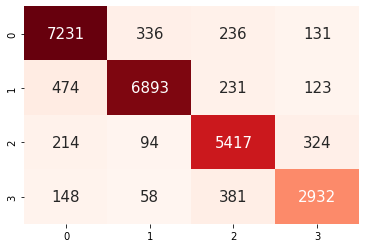

In [59]:
test_target = []

for batch in test_iterator:
    test_target += batch.main_category.tolist()

cm = confusion_matrix(test_target, total_predicted)
cm_df = pd.DataFrame(cm)

heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

In [60]:
class_report = classification_report(test_target, total_predicted)
print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7934
           1       0.93      0.89      0.91      7721
           2       0.86      0.90      0.88      6049
           3       0.84      0.83      0.83      3519

    accuracy                           0.89     25223
   macro avg       0.88      0.88      0.88     25223
weighted avg       0.89      0.89      0.89     25223

